# Business Understanding
## Problem Statement

We were given a churn prediction problem. The goal is to predict whether a customer is about to leave (to churn) our bank.
This is a binary classification problem, where the target variable is the 'Exited' column, based on the other columns in the dataset.

## Business Objectives

This is a very important problem for the bank, as it is much more expensive to acquire new customers than to retain existing ones, therefore making it crucial to accurately predict which costumers are leaving, so that the bank can take action to retain them.

![churn.png](images/churn.png)

# Data Understanding and Preparation

The dataset contains 10,000 records and 13 columns (features). The features are as follows:

- **RowNumber**: The row number
- **CustomerId**: The customer ID
- **Surname**: The customer's surname
- **CreditScore**: The customer's credit score
- **Geography**: The customer's country (Spain / France / Germany)
- **Gender**: The customer's gender (Male / Female)
- **Age**: The customer's age
- **Tenure**: The number of years the customer has been with the bank
- **Balance**: The customer's account balance
- **NumOfProducts**: The number of bank products the customer uses
- **HasCrCard**: Whether the customer has a credit card (1 = Yes, 0 = No)
- **IsActiveMember**: Whether the customer is an active member (1 = Yes, 0 = No)
- **EstimatedSalary**: The customer's estimated salary
- **Exited**: Whether the customer has churned (1 = Yes, 0 = No)

First, we will load the data and perform some basic data exploration to understand the data better.

We start by mapping the categorical variables to numerical values, so that we can use them in our models, and dropping the columns that are not relevant for the prediction.


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Read data from csv fil
df = pd.read_csv('../Churn_Modelling.csv')

# Drop irrelevant columns
df = df.drop(columns = ['RowNumber', 'CustomerId', 'Surname'])

# Encode categorical columns
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df_encoded = pd.get_dummies(df, columns = ['Geography'], drop_first = True)
df = df_encoded


numeric_columns = df.select_dtypes(include='number').columns

# Check for negative values
negative_values = (df[numeric_columns] < 0).sum()
if negative_values.sum() == 0:
    print('No negative values')

# Check for missing values
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print('No missing values')

# Check for invalid age values
invalid_age_values = (df['Age'] < 18) | (df['Age'] > 100)
if invalid_age_values.sum() == 0:
    print('No invalid age values')

# Check for balance between churned and retained customers
# churned when column exited is 1
churned = df['Exited'].sum()
retained = df.shape[0] - churned
print(f'ratio churned/retained: {churned}/{retained}')

min_unique_values = 8
relevant_columns = [col for col in df.columns if (df[col].nunique() >= min_unique_values) or (col == 'Exited')]
relevant_columns_df = df[relevant_columns]

#sns.pairplot(relevant_columns_df, hue='Exited')

No negative values
No missing values
No invalid age values
ratio churned/retained: 2037/7963


## Data Exploration Conclusion
The dataset is also imbalanced, with 79.63% of the customers not churning (Exited = 0) and 20.37% of the customers churning (Exited = 1).

From the pairplots, we can see the model is clean and there are no missing values.


# Data Modeling and Evaluation Metrics

We will start by splitting the data into training and testing sets, and then we will train several models and evaluate their performance using the following metrics:

- **Accuracy**: The proportion of correctly classified instances.
- **Precision**: The proportion of true positive instances among the instances classified as positive.
- **Recall**: The proportion of true positive instances that were correctly classified.
- **F1 Score**: The harmonic mean of precision and recall.

We will train the following models:

- Logistic Regression ??????
- Support Vector Machine
- K-Nearest Neighbors
- Neural Network
- Decision Tree


Best parameters found: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}


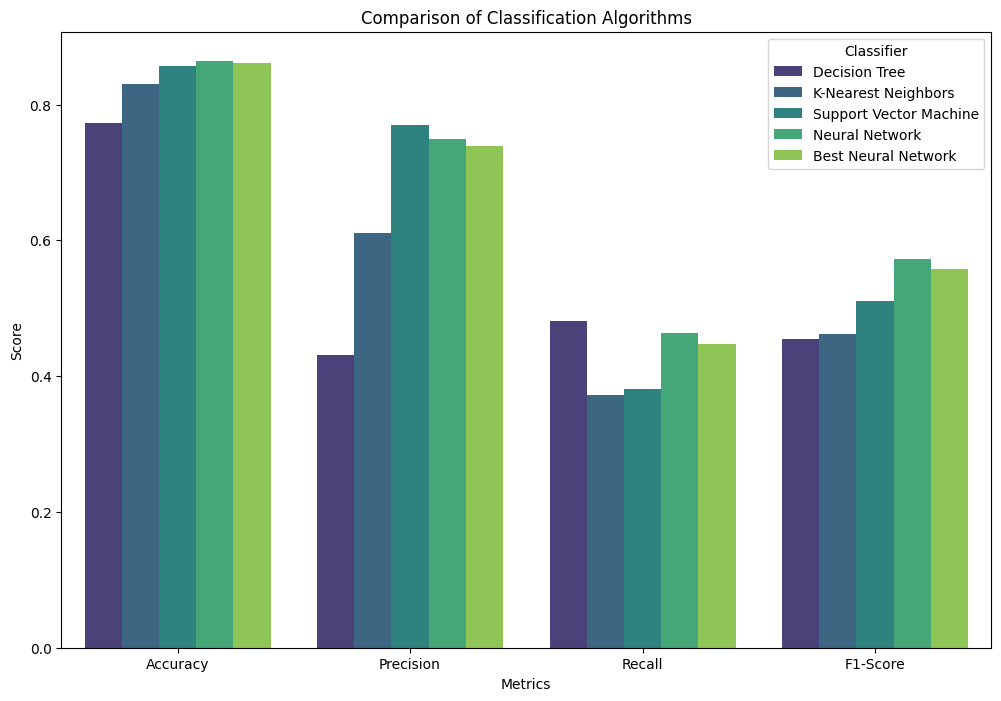

In [21]:
# Define 'X' (features) and 'y' (target variable)
X = df.drop(columns=['Exited'])
y = df['Exited']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "Neural Network": MLPClassifier(max_iter=2000, early_stopping=True)  # Increase max_iter and enable early stopping
}

# Define the parameter grid for MLPClassifier
param_grid = {
    'hidden_layer_sizes': [(50, 50), (100,), (100, 50, 30)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
}

# Perform Grid Search
grid_search = GridSearchCV(MLPClassifier(max_iter=2000, early_stopping=True), param_grid, n_jobs=-1, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters found by Grid Search
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the best model with the best parameters
best_mlp = grid_search.best_estimator_

# Evaluate each classifier
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results[name] = [accuracy, precision, recall, f1]

# Add the best neural network results
best_mlp.fit(X_train, y_train)
y_pred = best_mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
results["Best Neural Network"] = [accuracy, precision, recall, f1]

# Convert results to DataFrame for visualization
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Reshape the DataFrame to a long format
results_long_df = results_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
results_long_df.rename(columns={'index': 'Classifier'}, inplace=True)

# Plot results
plt.figure(figsize=(12, 8))
sns.barplot(data=results_long_df, x='Metric', y='Score', hue='Classifier', palette='viridis')
plt.title('Comparison of Classification Algorithms')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.legend(title='Classifier')
plt.show()


# Improving the Model

We will try to improve the model by performing the following steps: (TODO: Add more details)

- Confusion Matrix
- Cross-Validation
- Over/Under Sampling
- Paramenter Tuning
- Grid Search

- Adjust Learning Rate
- Use early stop
- Standardize the data